<a href="https://colab.research.google.com/github/dukei/dls-fr/blob/master/DLS-project-FR-1_dop_Identification_Rate_Metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identification Rate Metric

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. Посчитаем косинусные сходства между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных сходства между всеми тремя парами из этих фото.
2. Посчитаем косинусные сходства между лицами, соответствующими разным людям из query части.
3. Посчитаем косинусные сходства между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных сходств false пар в порядке убывания. N — ое значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное сходство больше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного сходства для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них сходство меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

**Для подсчета метрик, то вам нужно разбить данные на query и distractors самим.**

Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

## План заданий

* Правильно разбить датасет на query и distractors
* Реализовать метрику и пройти все тесты
* Подгрузить все модели, обученные на разных лоссах и сравнить их метрики

# Загрузка классов

In [ ]:
# Распознавание лиц
%run celeba_dataset/faces_recognition.py

# Классы для датасета
%run celeba_dataset/faces_dataset.py

# Создание датасетов

Создадим датасет для квери и дистракторов. Возьмем в квери 10 человек, в дистракторы 1000.

Посчитаем количество пар для этих чисел:

**Positive пары (Шаг 1)**: У вас 10 личностей в query, и у каждой по 5 изображений. Количество пар для одной личности: C(5, 2) = (5 * 4) / 2 = 10 пар. Всего positive пар: 10 личностей * 10 пар/личность = **100 пар**.

**Negative пары из query (Шаг 2)**: Общее количество изображений в query - 10 личностей * 5 изображений/личность = 50 изображений. Общее количество всех возможных пар в query: C(50, 2) = (50 * 49) / 2 = 1225 пар. Вычитаем positive пары: 1225 - 100 = **1125 пар**.

**Negative пары из query и distractors (Шаг 3)**: Количество изображений в query = 50. Количество изображений в distractors = 1000 личностей * 5 изображений/личность = 5000 изображений. Количество пар: 50 * 5000 = **250 000 пар**.

**Общее количество false пар (Шаг 4)**: Сумма negative пар из query и пар query-distractors: 1125 + 250 000 = **251 125 пар**.

Таким образом, общее количество всех пар (positive и false), которые будут вычислены для метрики identification rate, составит: 100 + 1125 + 250 000 = **251 225 пар**

In [ ]:
import random

# Загружаем оригинальные датафреймы, чтобы найти общие идентичности
original_test_df = pd.read_csv('celeba_dataset/fr/test_25_frontal_df.csv', index_col="image_id")
original_test_20_df = pd.read_csv('celeba_dataset/fr/test_20_frontal_df.csv', index_col="image_id")

# Находим уникальные идентичности в каждом датафрейме
test_identities = set(original_test_df['identity'].unique())
test_20_identities = set(original_test_20_df['identity'].unique())

# Находим пересечение идентичностей (идентичности, которые есть и в train, и в val)
common_identities = sorted(list(test_identities.intersection(test_20_identities)))

print(f"Количество общих идентичностей между train_25 и train_20: {len(common_identities)}")

query_distractors_identities = random.sample(common_identities, 1010)
distractors = query_distractors_identities[:1000]
query = query_distractors_identities[1000:]

query_df = original_test_20_df[original_test_20_df['identity'].isin(query)]
distractors_df = original_test_20_df[original_test_20_df['identity'].isin(distractors)]
dataset_df = original_test_20_df[original_test_20_df['identity'].isin(query_distractors_identities)]

print(f"Query dataset size (common identities): {len(query_df)}")
print(f"Distractor dataset size (common identities): {len(distractors_df)}")



Количество общих идентичностей между train_25 и train_20: 6583
Query dataset size (common identities): 50
Distractor dataset size (common identities): 5000


In [ ]:
import kagglehub

# Предсказанные нашей моделью лэндмарки
pred_landmarks_df = pd.read_csv('celeba_dataset/fr/predicted_landmarks.csv', index_col='image_id')
# Улучшенные bbox лиц для диких картинок
bbox_df = pd.read_csv('celeba_dataset/list_bbox_celeba_better.csv', index_col='image_id')

dataset_name = 'kevinpatel04/celeba-original-wild-images'
source_dir = kagglehub.dataset_download(dataset_name)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Шаблон кода для Identificaton rate metric (TPR@FPR)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np # Import numpy for clipping
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

def compute_embeddings(model, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''

  # Определяем атрибуты для FacesDataset
  attribs_dict = {
      "landmarks": pred_landmarks_df,
      "bbox": bbox_df
  }

  dataset = FacesDataset(images_list, base_dir=source_dir, image_size=240, mode='test', attribs=attribs_dict, align_face=True, cache_dir='cache_cd')
  test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

  # Визуализация первых четырех изображений из датасета
  print("Визуализация первых 4 изображений из датасета:")
  plt.figure(figsize=(16, 4)) # Adjust figure size for a single row of 4 images
  for i in range(min(4, len(dataset))):
      # Получаем изображение и метку из датасета
      img_tensor, _ = dataset[i]

      # Convert mean and std to tensors and reshape for broadcasting
      mean_tensor = torch.tensor(NORMALIZE_MEAN).view(3, 1, 1)
      std_tensor = torch.tensor(NORMALIZE_STD).view(3, 1, 1)

      # Denormalize the image
      img_display = img_tensor.cpu() * std_tensor + mean_tensor
      img_display = np.clip(img_display.permute(1, 2, 0).cpu().numpy(), 0, 1) # Clamp values and convert to numpy for matplotlib

      plt.subplot(1, 4, i + 1) # Changed to 1 row, 4 columns
      plt.imshow(img_display)
      plt.title(images_list[i]) # Используем имя файла из images_list
      plt.axis('off')
  plt.tight_layout()
  plt.show()

  all_embeddings = []
  with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Вычисление эмбеддингов"):
        images = images.to(device)
        embeddings = model(images, return_features_only=True)
        all_embeddings.append(embeddings.cpu())

  return all_embeddings

Пробуем лучшую модель (AdaCos, обученную на 2131 классе)

In [ ]:
face_recognition_model_20_adacos = FaceRecognitionModel(
    num_classes=2131,
    backbone_name='efficientnet_b1',
    loss_type='adacos'
)
face_rec_model_path = 'celeba_dataset/checkpoints/best_model_efficientnet_20_adacos.pth'
face_recognition_model_20_adacos.load_state_dict(torch.load(face_rec_model_path, map_location=device))

face_recognition_model_20_adacos = face_recognition_model_20_adacos.to(device)
face_recognition_model_20_adacos.eval() # Установка режима оценки


FaceRecognitionModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

Визуализация первых 4 изображений из датасета:


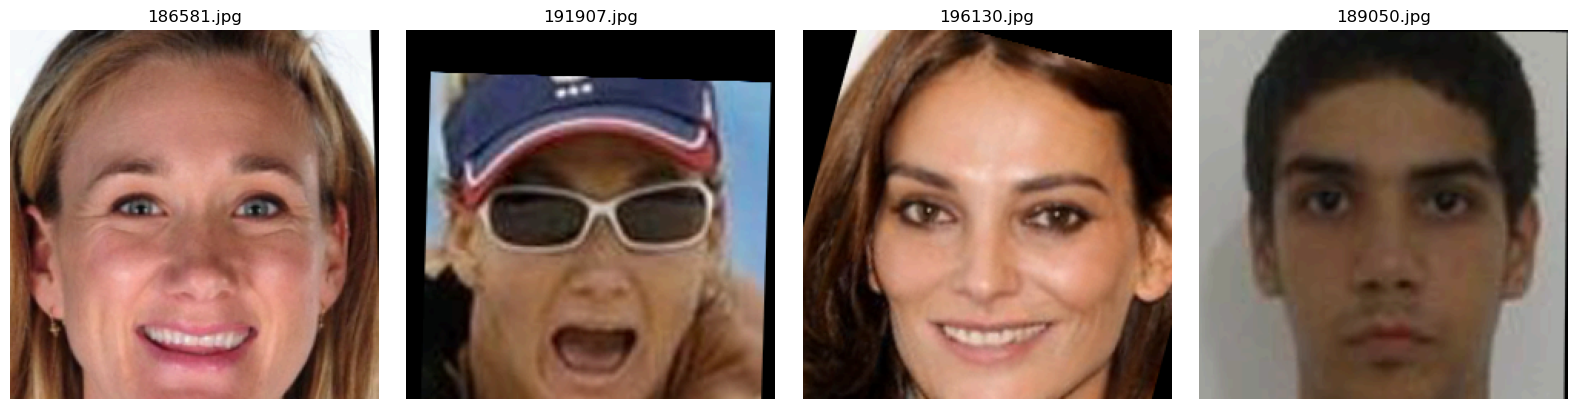

Вычисление эмбеддингов:   0%|          | 0/1 [00:00<?, ?it/s]

Визуализация первых 4 изображений из датасета:


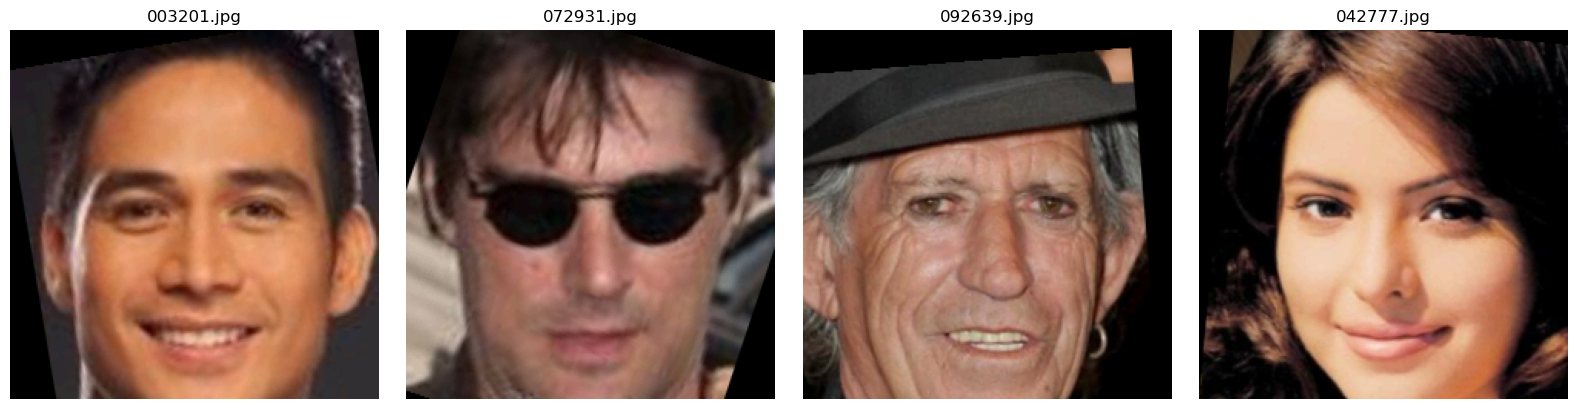

Вычисление эмбеддингов:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
model = face_recognition_model_20_adacos
query_embeddings = compute_embeddings(model, query_df.index)
distractors_embeddings = compute_embeddings(model, distractors_df.index)

In [ ]:
import itertools
import torch.nn.functional as F
import numpy as np

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: torch.Tensor of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  img_name_to_idx = {name: i for i, name in enumerate(query_img_names)}
  positive_similarities = []

  for identity_images in query_dict.values():
    for img1_name, img2_name in itertools.combinations(identity_images, 2):
      idx1 = img_name_to_idx[img1_name]
      idx2 = img_name_to_idx[img2_name]
      emb1 = query_embeddings[idx1]
      emb2 = query_embeddings[idx2]
      similarity = F.cosine_similarity(emb1, emb2, dim=0).item()
      positive_similarities.append(similarity)

  return positive_similarities

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: torch.Tensor of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  # Create a mapping from image name to identity for quick lookup
  img_name_to_identity = {}
  for identity, img_names in query_dict.items():
      for img_name in img_names:
          img_name_to_identity[img_name] = identity

  img_name_to_idx = {name: i for i, name in enumerate(query_img_names)}
  negative_similarities_query = []

  for img1_name, img2_name in itertools.combinations(query_img_names, 2):
    if img_name_to_identity[img1_name] != img_name_to_identity[img2_name]:
      idx1 = img_name_to_idx[img1_name]
      idx2 = img_name_to_idx[img2_name]
      emb1 = query_embeddings[idx1]
      emb2 = query_embeddings[idx2]
      similarity = F.cosine_similarity(emb1, emb2, dim=0).item()
      negative_similarities_query.append(similarity)

  return negative_similarities_query

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: torch.Tensor of embeddings corresponding to query_img_names
    distractors_embeddings: torch.Tensor of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  negative_similarities_distractors = []
  for q_emb in query_embeddings:
    for d_emb in distractors_embeddings:
      similarity = F.cosine_similarity(q_emb, d_emb, dim=0).item()
      negative_similarities_distractors.append(similarity)

  return negative_similarities_distractors

In [ ]:
import torch

# Создаем словарь query_dict
query_dict = {int(k): v for k, v in query_df.groupby('identity').apply(lambda x: x.index.tolist()).to_dict().items()}

# Создаем список имен изображений query
query_img_names = query_df.index.tolist()

# Объединяем эмбеддинги query в один тензор
concatenated_query_embeddings = torch.cat(query_embeddings, dim=0)

# Объединяем эмбеддинги distractors в один тензор
concatenated_distractors_embeddings = torch.cat(distractors_embeddings, dim=0)

# Вызываем compute_cosine_query_pos
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            concatenated_query_embeddings)

# Вызываем compute_cosine_query_neg
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            concatenated_query_embeddings)

# Вызываем compute_cosine_query_distractors
cosine_query_distractors = compute_cosine_query_distractors(concatenated_query_embeddings,
                                                            concatenated_distractors_embeddings)

/tmp/ipykernel_1671/624678296.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  query_dict = {int(k): v for k, v in query_df.groupby('identity').apply(lambda x: x.index.tolist()).to_dict().items()}


Ячейка ниже проверяет, что код работает верно:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings_list = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]
test_query_embeddings = torch.tensor(test_query_embeddings_list, dtype=torch.float32)

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings_list = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]
test_distractors_embeddings = torch.tensor(test_distractors_embeddings_list, dtype=torch.float32)

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [ ]:
import numpy as np

def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  false_similarities = np.array(cosine_query_neg + cosine_query_distractors)
  # Сортируем по убыванию, чтобы легко найти N-ое наибольшее значение
  false_similarities_sorted_desc = np.sort(false_similarities)[::-1]

  total_false_pairs = len(false_similarities_sorted_desc)
  total_positive_pairs = len(cosine_query_pos)

  threshold = 0.0 # Порог по умолчанию

  if total_false_pairs == 0:
    # Если нет ложных пар, любой порог действителен для FPR. Установка на 1.0
    # означает, что ложных срабатываний быть не может, максимизируя TPR, если есть положительные пары.
    threshold = 1.0
  else:
    # Вычисляем N, количество допустимых ложных срабатываний (отсчет с 1).
    # Описание задачи указывает на "N — ое значение расстояния", что подразумевает взятие N-го элемента.
    # Для дробных N обычно используется numpy.ceil для определения ранга.
    num_allowed_fp_count = int(np.ceil(fpr * total_false_pairs))

    if num_allowed_fp_count <= 0:
        # Если разрешено 0 или отрицательное количество ложных срабатываний (например, fpr=0),
        # порог должен быть установлен очень высоким, чтобы исключить ложные срабатывания.
        # Косинусное сходство не может быть больше 1.0.
        threshold = 1.0
    elif num_allowed_fp_count >= total_false_pairs:
        # Если разрешены все ложные срабатывания (например, fpr=1),
        # порог должен быть установлен очень низким, чтобы включить все ложные срабатывания.
        # Косинусное сходство не может быть меньше -1.0.
        threshold = -1.0
    else:
        # N-ое наибольшее значение (отсчет с 1 означает индекс num_allowed_fp_count - 1 для 0-индексированного массива).
        threshold = false_similarities_sorted_desc[num_allowed_fp_count - 1]

  # Вычисляем TPR
  # Считаем количество положительных пар со сходством, большим или равным вычисленному порогу.
  true_positives = np.sum(np.array(cosine_query_pos) >= threshold)
  tpr = true_positives / total_positive_pairs if total_positive_pairs > 0 else 0.0

  return threshold, tpr

И ячейки для ее проверки:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

# Финальная метрика

In [ ]:
fpr_values = [0.5, 0.2, 0.1, 0.05, 0.01]

print("Calculating TPR@FPR for the given FPR values:")
for fpr_val in fpr_values:
  threshold, tpr = compute_ir(cosine_query_pos, cosine_query_neg,
                                  cosine_query_distractors, fpr=fpr_val)
  print(f"FPR: {fpr_val:.2f}, Threshold: {threshold:.4f}, TPR: {tpr:.4f}")

Calculating TPR@FPR for the given FPR values:
FPR: 0.50, Threshold: 0.0211, TPR: 0.6700
FPR: 0.20, Threshold: 0.0969, TPR: 0.4200
FPR: 0.10, Threshold: 0.1595, TPR: 0.3400
FPR: 0.05, Threshold: 0.2270, TPR: 0.2900
FPR: 0.01, Threshold: 0.3775, TPR: 0.2000


По метрике EER и ROC AUC качество модели казалось лучше... А тут какие-то 0.29 TPR@FRP=0.05. Как-то немного...